##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Probabilistic Layers: Variational Auto Encoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this example we show how to fit a Variational Autoencoder using TFP's "probabilistic layers."

### Dependencies & Prerequisites


In [17]:
#@title Import { display-mode: "form" }


import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

# # TO SOLVE THE ISSUE from vae.fit, (UNIMPLEMENTED: DNN library is not found. or
# # InternalError: libdevice not found at ./libdevice.10.bc) arising from running TF and JAX concurrently
# # REFER TO: https://github.com/google/jax/issues/4920#issuecomment-1426065017
# # Reducing the allocation of memory by TF: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # # Currently, memory growth needs to be the same across GPUs
#     # for gpu in gpus:
#     #   tf.config.experimental.set_memory_growth(gpu, True)
#     # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)
# # If the error (UNIMPLEMENTED: DNN library is not found. or InternalError: libdevice not found at ./libdevice.10.bc)
# # still persists restricting usage of GPU entirely by setting visiable devices
tf.config.experimental.set_visible_devices([], 'GPU')
# also try reducing JAX memory usage as below
# # JAX memory allocation: https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html#common-causes-of-oom-failures
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".50"


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

### Make things Fast!

Before we dive in, let's make sure we're using a GPU for this demo.  

To do this, select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

The following snippet will verify that we have access to a GPU.

In [18]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


Note: if for some reason you cannot access a GPU, this colab will still work. (Training will just take longer.)

### Load Dataset

In [19]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
  return image, image

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3)))
eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.AUTOTUNE))

Note that _preprocess() above returns `image, image` rather than just `image` because Keras is set up for discriminative models with an (example, label) input format, i.e. $p_\theta(y|x)$. Since the goal of the VAE is to recover the input x from x itself (i.e. $p_\theta(x|x)$), the data pair is (example, example).

### VAE Code Golf

#### Specify model.

In [20]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

In [21]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [22]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

In [23]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

In [24]:
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

#### Do inference.

In [11]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

_ = vae.fit(train_dataset,
            epochs=15,
            validation_data=eval_dataset)
vae.save_weights("trained_model/digit")

Epoch 1/15
  8/235 [>.............................] - ETA: 2:35 - loss: 156.6555

KeyboardInterrupt: 

In [25]:
vae.load_weights("trained_model/digit")

In [27]:
encoder.predict(dataset_sample)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'dict\'> containing {"<class \'str\'>"} keys and {"<class \'numpy.int64\'>", "<class \'numpy.ndarray\'>"} values)'}), <class 'NoneType'>

In [82]:
n_image = 500
# Data and label in TF format
data = next(iter(datasets['test'].map(lambda x: (x["image"])).batch(n_image)))
label = next(iter(datasets['test'].map(lambda x: (x["label"])).batch(n_image)))
latent_repr = encoder.predict(data)
decoded_data = vae.predict(data)

# Conversion of data and label to NP format
np_data = np.array(data)
np_label = np.array(label)
flattened_data = np_data.reshape(n_image, -1)
np_latent_repr = np.array(latent_repr)
np_decoded_data = np.array(decoded_data)
flattened_decoded_data = np_decoded_data.reshape(n_image, -1)

16/16 [==============================] - 1s 31ms/step


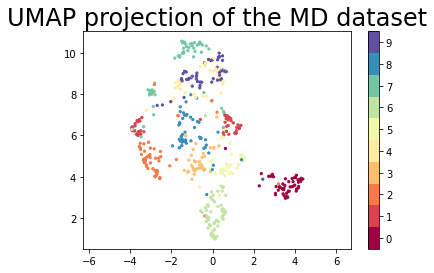

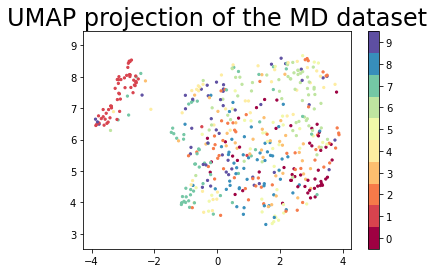

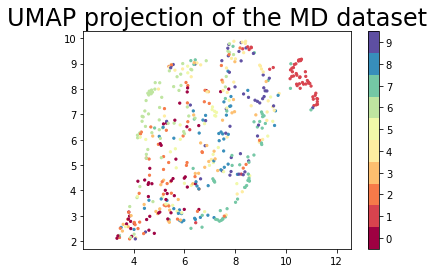

In [83]:
import numpy as np
import umap
import matplotlib.pyplot as plt
digit_reducer = umap.UMAP(random_state=42)
digit_reducer.fit(flattened_data)
digit_embedding = digit_reducer.transform(flattened_data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(digit_embedding == digit_reducer.embedding_))
plt.figure()
plt.scatter(digit_embedding[:, 0], digit_embedding[:, 1], c=np_label, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the MD dataset', fontsize=24);

latent_digit_reducer = umap.UMAP(random_state=42)
latent_digit_reducer.fit(np_latent_repr)
latent_digit_embedding = latent_digit_reducer.transform(np_latent_repr)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(latent_digit_embedding == latent_digit_reducer.embedding_))
plt.figure()
plt.scatter(latent_digit_embedding[:, 0], latent_digit_embedding[:, 1], c=np_label, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the MD dataset', fontsize=24);

decoded_data_reducer = umap.UMAP(random_state=42)
decoded_data_reducer.fit(flattened_decoded_data)
decoded_data_embedding = decoded_data_reducer.transform(flattened_decoded_data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(decoded_data_embedding == decoded_data_reducer.embedding_))
plt.figure()
plt.scatter(decoded_data_embedding[:, 0], decoded_data_embedding[:, 1], c=np_label, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the MD dataset', fontsize=24);

### Look Ma, No ~~Hands~~Tensors!

In [ ]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

In [ ]:
#@title Image Plot Util
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

In [ ]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

In [ ]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

In [ ]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())